#Recurrent Neural Networks

In [1]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional, Embedding, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re

np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',200)



2024-11-28 21:46:53.517740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 21:46:53.610859: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 21:46:53.627886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 21:46:53.672685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 21:46:55.451392: W tensorflow/compiler/tf2

## Predictive maintenance

Your task is to train a Machine learning/deep learning model for predicting failures in engines. The file 'failures.csv' contains the the necessary data.
This particular dataset was created by measuring 100 jet engines (of the same type) and counting how many cycles they were still operational before a failure manifested itself. 


The dataset is structured as follows:
- engine_ID = The ID of a particular engine.
- cycle = Number of the engine cycle.
- setting1, setting2, setting3 = the different operational modes.
- other features: measurements of the 21 different sensors.
- ttf = time to failure: how many more engine cycles left before an engine failure occurs.


A first approach is to simplify the problem by transforming it into a **classification problem**. Here you try to predict whether or not the engine will fail within a certain number of cycles. For example, within the next 50 cycles. 


The second approach is to consider the problem as a **regression problem** where you try to predict the actual remaining cycles (ttf).


### 1.1 TTF classification

In [2]:
# Loading the dataset

df = pd.read_csv('failures.csv')
df.tail()

,engine_id,cycle,setting1,setting2,setting3,temp_fan_inlet,temp_lpc_outlet,temp_hpc_outlet,temp_lpt_outlet,pressure_fan_inlet,pressure_bypass_duct,pressure_hpc_outlet,physical_fan_speed,physical_core_speed,engine_pressure_ratio,static_pressure_hpc_outlet,fuel_flow_ration_ps30,corrected_fan_speed,corrected_core_speed,bypass_ratio,burner_fuel_air_ratio,bleed_enthalpy,demanded_fan_speed,demanded_corrected_fan_speed,hpt_collant_bleed,lpt_coolant_bleed,ttf
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,21.61,550.79,2388.26,9061.48,1.3,48.20,519.30,2388.26,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,0


In [3]:
df.shape

(20631, 27)

#### Preprocessing

Add an additional 'failure' column to the dataset that represents whether or not the engine will fail within 50 cycles. In other words, if the ttf is still larger than 50, the value is 0; if the ttf is less than or equal to 50, the value is equal to 1.

Also check the balancedness of the dataset.

In [4]:
# Adding a 'failure' column

df["failure"] = df["ttf"].apply(lambda x: 1 if x<=50 else 0)
df.head()

,engine_id,cycle,setting1,setting2,setting3,temp_fan_inlet,temp_lpc_outlet,temp_hpc_outlet,temp_lpt_outlet,pressure_fan_inlet,pressure_bypass_duct,pressure_hpc_outlet,physical_fan_speed,physical_core_speed,engine_pressure_ratio,static_pressure_hpc_outlet,fuel_flow_ration_ps30,corrected_fan_speed,corrected_core_speed,bypass_ratio,burner_fuel_air_ratio,bleed_enthalpy,demanded_fan_speed,demanded_corrected_fan_speed,hpt_collant_bleed,lpt_coolant_bleed,ttf,failure
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


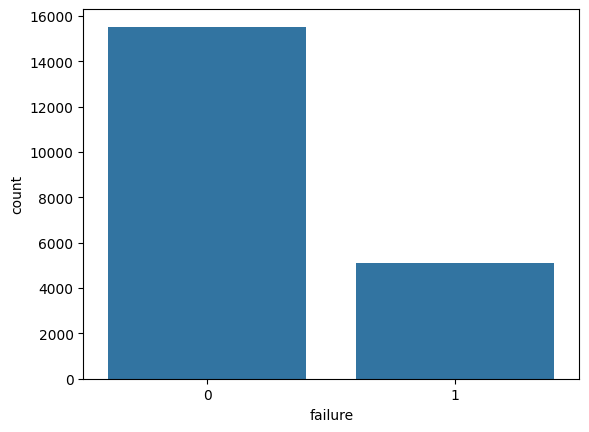

The data is heavily imbalanced.


In [4]:
# Balancedness
plt.figure()
sns.countplot(x=df["failure"])
plt.show()

print("The data is heavily imbalanced.")

####  Prediction based on single data samples (memoryless)

Before considering the data as a time series and thus training LSTM or GRU models, it's interesting to first check how well you can make accurate predict with models that do not use the temporal component and consider each measurement independently of the previous ones.
Concretely, you try to predict the target for a given time, based on the features without looking at the previous measurements. Each row in the dataset is considered independently of the other rows.

- Split the dataset into a training set and a test set. The first 75 engines are used for training, the other engines for testing.
- Train a logistic regression classifier and a random forest tree on the training set and evaluate with the test set. Discuss the obtained results.
- Train a vanilla neural network (a classical feedforward neural network). Evaluate and discuss.

In [5]:
train_df = df[df["engine_id"]<=75].drop("ttf", axis =1 )

test_df = df[df["engine_id"]>75].drop("ttf", axis =1 )

# REMOVE TTF

In [ ]:
# Split into training set and test set

y_train = train_df["failure"].values
X_train = train_df.drop("failure", axis = 1).values

y_test = test_df["failure"].values
X_test = test_df.drop("failure", axis = 1).values

# Scaling
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15159, 26) (15159,)
(5472, 26) (5472,)


In [10]:
# Logistic regression

log_reg = LogisticRegression(class_weight='balanced', solver="liblinear")
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print("\nClassification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)



Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      4197
           1       0.77      0.89      0.82      1275

    accuracy                           0.91      5472
   macro avg       0.87      0.90      0.88      5472
weighted avg       0.92      0.91      0.91      5472

Confusion Matrix:
 [[3850  347]
 [ 138 1137]]
Accuracy: 0.9113669590643275


In [14]:
# Random Forest Trees

rf_trees = RandomForestClassifier(n_estimators=200, random_state=42)
rf_trees.fit(X_train, y_train)

y_pred = rf_trees.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print("\nClassification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)



Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      4197
           1       0.91      0.78      0.84      1275

    accuracy                           0.93      5472
   macro avg       0.92      0.88      0.90      5472
weighted avg       0.93      0.93      0.93      5472

Confusion Matrix:
 [[4100   97]
 [ 278  997]]
Accuracy: 0.9314692982456141


In [8]:
# Vanilla neural network
epochs = 100
dropoutrate = 0.3
input_dim = X_train.shape[1]
batch_size = 32

activation_hidden = 'relu'
activation_output = 'sigmoid'
initializer = 'he_normal'

adam = tf.keras.optimizers.Adam()


model = Sequential() # empty neural network
# Layer 1
model.add(Dense(128, input_dim=input_dim, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Activation(activation_hidden))
model.add(Dropout(dropoutrate))

# Layer 2
model.add(Dense(64, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Activation(activation_hidden))
model.add(Dropout(dropoutrate))

# Layer 3
model.add(Dense(32, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Activation(activation_hidden))
model.add(Dropout(dropoutrate))

# Layer 4
model.add(Dense(16, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Activation(activation_hidden))
model.add(Dropout(dropoutrate))

# Output Layer
model.add(Dense(1, kernel_initializer=initializer, activation=activation_output))


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.3, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=early_stopping)




I0000 00:00:1732186094.324708  213687 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732186094.350932  213687 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732186094.351003  213687 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732186094.354412  213687 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732186094.354509  213687 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/100


I0000 00:00:1732186096.910900  213832 service.cc:146] XLA service 0x7f3c380073e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732186096.910941  213832 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-11-21 11:48:16.950426: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-21 11:48:17.189163: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 88/332 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6202 - loss: 0.6633

I0000 00:00:1732186099.171292  213832 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7528 - loss: 0.4866 - val_accuracy: 0.8720 - val_loss: 0.2899
Epoch 2/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9081 - loss: 0.2307 - val_accuracy: 0.8810 - val_loss: 0.2676
Epoch 3/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9193 - loss: 0.2022 - val_accuracy: 0.8920 - val_loss: 0.2444
Epoch 4/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9247 - loss: 0.1913 - val_accuracy: 0.8802 - val_loss: 0.2743
Epoch 5/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9284 - loss: 0.1815 - val_accuracy: 0.8817 - val_loss: 0.2695
Epoch 6/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9221 - loss: 0.1918 - val_accuracy: 0.8949 - val_loss: 0.2454
Epoch 7/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9242 - loss: 0.1920 - val_accuracy: 0.8905 - val_loss: 0.2518
Epoch 8/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9234 - loss: 0.1873 - val_accuracy: 0.900

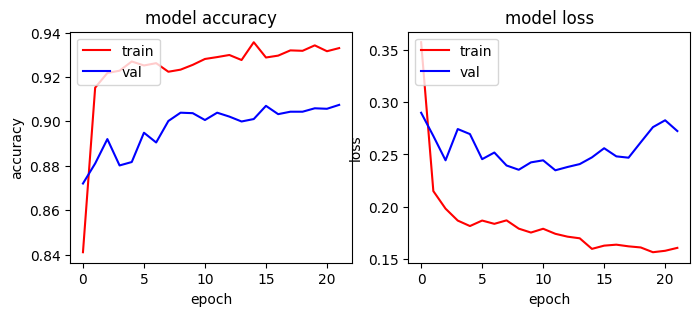

In [9]:
# history = model.fit(X_train, y_train, validation_split=0.3, epochs=epochs, verbose=1, batch_size=batch_size)

fig, axs = plt.subplots(1, 2,figsize=(8, 3))
axs[0].plot(history.history['accuracy'],'r')
axs[0].plot(history.history['val_accuracy'],'b')
axs[0].set_title(f'model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='upper left')
# Loss
axs[1].plot(history.history['loss'],'r')
axs[1].plot(history.history['val_loss'],'b')
axs[1].set_title(f'model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:

y_pred = []

for prob in model.predict(X_test):
  if prob<=0.50:
    y_pred.append(0)
  else:
    y_pred.append(1)


# Calculate Metrics
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print Results
print("\nClassification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      4197
           1       0.86      0.77      0.81      1275

    accuracy                           0.92      5472
   macro avg       0.90      0.87      0.88      5472
weighted avg       0.92      0.92      0.92      5472

Confusion Matrix:
 [[4036  161]
 [ 292  983]]
Accuracy: 0.9172149122807017


#### Time-series based prediction

One can assume that an accurate prediction of the enigne failures (within a certain time interval) is not only determined by the most recent measurement but can also be inferred in part from the past (previously measured values). This means that the models must take into account the current sample but also a number of previous samples. Therefore, we will resort to recurrent neurals networks (LSTM or GRU) which via feedback connections are ideally suited to capture time dependencies in time series.


Go through the following steps:

- Building the training set and test set:

The training set and test set consist of sequences of certain length (seq_length). To start, take a seq_length=30. To build these sequences proceed as follows:
Use a sliding window mechanism to create these sequences. The window starts at the row with the highest ttf and slides down row by row until the engine fails (last measurement of a specific engine). The samples within the window form a sequence (of 30 values in this case). This is a concatenation of the most recent measurement with 29 previous measurements. At the start there are no previous values, hence zero padding can be applied to still arrive at a sequence of 30. Instead of zero padding, you can also do padding with the edge values (copy the measurement at the beginning of the sequence). The target value associated with a sequence is the failure value correspending to the most recent measurement value in that sequence.

- Compile a training set and a test set. 

The samples (=sequences) coming from the first 75 engines go into the training set, the sequences from the other engines go to the test set. 


- scale the training set and test set (e.g. via a MinMAX scaler).


- Training a LSTM network

Train an LSTM on the training set and vary the hyperparameters to obtain the highest possible accuracy. Possible hyperparameters of the network are the batch size, number of layers, number of units per layer, dropout, recurrent dropout, optimizer, ...
Also try a bidirectional LSTM. For example: model.add(Bidirectional(LSTM(64)))

- Evaluate the LSTM network and compare its accuracy with that of the non-temporal models.

- Optimize the neural network to reduce the number of false negatives (a failure within 50 cycles that has not been detected)

- Investigate whether you get better results with longer or shorter sequences.


In [5]:
train_df = df[df["engine_id"]<=75].drop("ttf", axis =1 )

test_df = df[df["engine_id"]>75].drop("ttf", axis =1 )

# REMOVE TTF

In [6]:
def pad_sequences(data, seq_length):
    padded_data = data.copy()
    while len(padded_data) < seq_length:
        padded_row = padded_data.iloc[0].values
        padded_data = pd.concat([pd.DataFrame([padded_row], columns=padded_data.columns), padded_data], ignore_index=True)
    return padded_data

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length + 1):
        seq = data.iloc[i:i + seq_length, :-1].values  # All features except target
        target = data.iloc[i + seq_length - 1, -1]    # Target is at the last value of the window
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [7]:
# there are about 191 samples for each engine
SEQ_LENGTH = 100

X_train, y_train = [], []
for engine_id in train_df['engine_id'].unique():
    engine_data = train_df[train_df['engine_id'] == engine_id]
    engine_data_padded = pad_sequences(engine_data, SEQ_LENGTH)
    seqs, targets = create_sequences(engine_data_padded, SEQ_LENGTH)
    X_train.append(seqs)
    y_train.append(targets)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Prepare sequences for testing
X_test, y_test = [], []
for engine_id in test_df['engine_id'].unique():
    engine_data = test_df[test_df['engine_id'] == engine_id]
    engine_data_padded = pad_sequences(engine_data, SEQ_LENGTH)
    seqs, targets = create_sequences(engine_data_padded, SEQ_LENGTH)
    X_test.append(seqs)
    y_test.append(targets)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(7734, 100, 26) (7734,)
(2997, 100, 26) (2997,)


In [8]:
scaler = MinMaxScaler()
n_features = X_train.shape[2]

# Flatten data for scaling
X_train_flat = X_train.reshape(-1, n_features)
X_test_flat = X_test.reshape(-1, n_features)

# Fit scaler on training data
scaler.fit(X_train_flat)

# Transform sequences
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)


In [9]:
def build_lstm_model(input_shape, bidirectional=False, dropout_rate=0.2, lstm_units=64, loss='binary_crossentropy'):
    model = Sequential()

    if bidirectional:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=input_shape))
        model.add(Bidirectional(LSTM(int(lstm_units/2), return_sequences=False)))
    else:
        model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(int(lstm_units/2), return_sequences=False))



    model.add(Dropout(dropout_rate))
    model.add(Dense(lstm_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model


In [19]:
input_shape = (SEQ_LENGTH, n_features)
print(input_shape)

(100, 26)


##### Bidirectional LSTM

In [20]:
input_shape = (SEQ_LENGTH, n_features)
model = build_lstm_model(input_shape, bidirectional=True, dropout_rate=0.3, lstm_units=128)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


/home/sathv/.local/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.8043 - loss: 0.4055 - val_accuracy: 0.9114 - val_loss: 0.1854
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9281 - loss: 0.1662 - val_accuracy: 0.9509 - val_loss: 0.1252
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9409 - loss: 0.1425 - val_accuracy: 0.9599 - val_loss: 0.1192
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9452 - loss: 0.1271 - val_accuracy: 0.9470 - val_loss: 0.1412
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9393 - loss: 0.1428 - val_accuracy: 0.9489 - val_loss: 0.1301
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9422 - loss: 0.1310 - val_accuracy: 0.9522 - val_loss: 0.1503
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9439 - loss: 0.1258 - val_accuracy: 0.9405 - val_loss: 0.1427
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9564 - loss: 0.1011 - 

In [21]:
# Predictions on the test set
# SEQ LENGTH of 100
predictions = model.predict(X_test_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Accuracy and confusion matrix
accuracy = accuracy_score(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)
report = classification_report(y_test, predicted_classes)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print(f"\nAccuracy: {accuracy*100:.3f} %")



94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1737
           1       0.93      0.95      0.94      1260

    accuracy                           0.95      2997
   macro avg       0.94      0.95      0.95      2997
weighted avg       0.95      0.95      0.95      2997

Confusion Matrix:
 [[1641   96]
 [  63 1197]]

Accuracy: 94.695 %


In [ ]:
# Predictions on the test set
# SEQ LENGTH of 30

predictions = model.predict(X_test_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Accuracy and confusion matrix
accuracy = accuracy_score(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)
report = classification_report(y_test, predicted_classes)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print(f"\nAccuracy: {accuracy*100:.3f} %")



149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3472
           1       0.92      0.92      0.92      1275

    accuracy                           0.96      4747
   macro avg       0.94      0.95      0.94      4747
weighted avg       0.96      0.96      0.96      4747

Confusion Matrix:
 [[3363  109]
 [  97 1178]]

Accuracy: 95.660 %


##### LSTM

In [22]:
input_shape = (SEQ_LENGTH, n_features)
model = build_lstm_model(input_shape, bidirectional=False, dropout_rate=0.3, lstm_units=128)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


/home/sathv/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7956 - loss: 0.4126 - val_accuracy: 0.8132 - val_loss: 0.4802
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9100 - loss: 0.2142 - val_accuracy: 0.9438 - val_loss: 0.1692
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9175 - loss: 0.1919 - val_accuracy: 0.9431 - val_loss: 0.1631
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9091 - loss: 0.2201 - val_accuracy: 0.9451 - val_loss: 0.1414
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9441 - loss: 0.1293 - val_accuracy: 0.9502 - val_loss: 0.1408
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9469 - loss: 0.1315 - val_accuracy: 0.9379 - val_loss: 0.1622
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9529 - loss: 0.1170 - val_accuracy: 0.9444 - val_loss: 0.1356
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9468 - loss: 0.1209 - val_accu

In [10]:
input_shape = (SEQ_LENGTH, n_features)
model = build_lstm_model(input_shape, bidirectional=False, dropout_rate=0.3, lstm_units=128)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping]
)


I0000 00:00:1732826852.613895 3580545 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732826852.728629 3580545 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732826852.728746 3580545 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732826852.731408 3580545 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732826852.731492 3580545 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/50


2024-11-28 21:47:44.608556: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 0.7352 - loss: 0.5233 - val_accuracy: 0.7809 - val_loss: 0.4430
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.8568 - loss: 0.3063 - val_accuracy: 0.8959 - val_loss: 0.2751
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9188 - loss: 0.1926 - val_accuracy: 0.9379 - val_loss: 0.1531
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.9284 - loss: 0.1707 - val_accuracy: 0.9522 - val_loss: 0.1166
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9289 - loss: 0.1644 - val_accuracy: 0.9476 - val_loss: 0.1423
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9445 - loss: 0.1341 - val_accuracy: 0.9011 - val_loss: 0.2333
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9377 - loss: 0.1482 - val_accuracy: 0.9586 - val_loss: 0.1205
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9513 - loss: 0.1173 - val_accuracy: 0.9399 - val_loss:

In [11]:
# Predictions on the test set
# batch 128
predictions = model.predict(X_test_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Accuracy and confusion matrix
accuracy = accuracy_score(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)
report = classification_report(y_test, predicted_classes)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print(f"\nAccuracy: {accuracy*100:.3f} %")


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      1737
           1       0.89      0.95      0.92      1260

    accuracy                           0.93      2997
   macro avg       0.93      0.93      0.93      2997
weighted avg       0.93      0.93      0.93      2997

Confusion Matrix:
 [[1581  156]
 [  57 1203]]

Accuracy: 92.893 %


In [23]:
# Predictions on the test set
#   SEQ LENGTH 100
predictions = model.predict(X_test_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Accuracy and confusion matrix
accuracy = accuracy_score(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)
report = classification_report(y_test, predicted_classes)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print(f"\nAccuracy: {accuracy*100:.3f} %")



94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      1737
           1       0.96      0.91      0.94      1260

    accuracy                           0.95      2997
   macro avg       0.95      0.94      0.95      2997
weighted avg       0.95      0.95      0.95      2997

Confusion Matrix:
 [[1694   43]
 [ 110 1150]]

Accuracy: 94.895 %


In [ ]:
# Predictions on the test set
# SEQ LENGTH 50
predictions = model.predict(X_test_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Accuracy and confusion matrix
accuracy = accuracy_score(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)
report = classification_report(y_test, predicted_classes)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print(f"\nAccuracy: {accuracy*100:.3f} %")



149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      3472
           1       0.92      0.83      0.87      1275

    accuracy                           0.93      4747
   macro avg       0.93      0.90      0.91      4747
weighted avg       0.93      0.93      0.93      4747

Confusion Matrix:
 [[3379   93]
 [ 218 1057]]

Accuracy: 93.448 %


#### Classification Oberservations 
* longer sequences seem to result in better results in both standard and bidirectional LSTMs.
* The LSTMs proved to be much better than the non-temporal models. 
* The logistic regression model is by far the best performing one out of the non-temporal models in terms of recall. Both RandomForest and the simple NN struggle to balance the accuracy between the 2 classes. 
* The logreg model struggles with precision.
* The LSTMs average a higher recall and precision rate.
* The best performing LSTM was a bidrectional one trained on sequences of length 100.

## 1.2 Regression of the TTF

- Instead of predicting whether the engine will fail within 50 cycles, you here predict the number of remaining cycles. The target is now the time to failure (ttf).
- Again, split the data set into a training set and a test set. The data from the first 75 engines is used as training data, the measurements from other engines are test data.
- Train a linear regression model and a random forest regressor on the training set and evaluate with the test set. Discuss the abtained results in terms of Mean Absolute Error (MAE) and the R² score.
- Next, train an LSTM. This is similar to what you did in the classification part of this assignment. Be sure to use the correct activation- and loss functions. Compare the obtained MAE and R² score with those of the non-temporal models.

In [12]:
train_df_regression = df[df["engine_id"]<=75].drop("failure", axis =1 )

test_df_regression = df[df["engine_id"]>75].drop("failure", axis =1 )


##### Linear Regression and Random Forest Regressor

In [ ]:
# Split into training set and test set

y_train_regression = train_df_regression["ttf"].values
X_train_regression = train_df_regression.drop("ttf", axis = 1).values

y_test_regression = test_df_regression["ttf"].values
X_test_regression = test_df_regression.drop("ttf", axis = 1).values

# Scaling
scaler = MinMaxScaler()

scaler.fit(X_train_regression)
X_train_regression = scaler.transform(X_train_regression)
X_test_regression = scaler.transform(X_test_regression)

print(X_train_regression.shape, y_train_regression.shape)
print(X_test_regression.shape, y_test_regression.shape)

(15159, 26) (15159,)
(5472, 26) (5472,)


In [ ]:
# Regression of the TTF with a linear regression model and a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_regression, y_train_regression)

y_pred =  rf_regressor.predict(X_test_regression)

mse = mean_squared_error(y_test_regression, y_pred)
mae = mean_absolute_error(y_test_regression, y_pred)
r2 = r2_score(y_test_regression, y_pred)


print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 2971.947453527047
Mean Absolute Error (MAE): 38.37113486842105
R-squared (R2): 0.4712488242155153


In [8]:
lr_model = LinearRegression()
lr_model.fit(X_train_regression, y_train_regression)
y_pred = lr_model.predict(X_test_regression)

mse = mean_squared_error(y_test_regression, y_pred)
mae = mean_absolute_error(y_test_regression, y_pred)
r2 = r2_score(y_test_regression, y_pred)


print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 2172.594265924342
Mean Absolute Error (MAE): 37.81124770830081
R-squared (R2): 0.6134649785793493


##### LSTM

In [66]:
train_df_regression.iloc[0,-1]

191

In [ ]:
import numpy as np
import pandas as pd

SEQ_LENGTH = 50

# Prepare training data
X_train, y_train = [], []
for engine_id in train_df_regression['engine_id'].unique():
    engine_data = train_df_regression[train_df_regression['engine_id'] == engine_id].select_dtypes(include=[np.number])
    engine_data_padded = pad_sequences(engine_data, SEQ_LENGTH)
    seqs, targets = create_sequences(engine_data_padded, SEQ_LENGTH)
    X_train.append(seqs)
    y_train.append(targets)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Prepare testing data
X_test, y_test = [], []
for engine_id in test_df_regression['engine_id'].unique():
    engine_data = test_df_regression[test_df_regression['engine_id'] == engine_id].select_dtypes(include=[np.number])
    engine_data_padded = pad_sequences(engine_data, SEQ_LENGTH)
    seqs, targets = create_sequences(engine_data_padded, SEQ_LENGTH)
    X_test.append(seqs)
    y_test.append(targets)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11484, 50, 26) (11484,)
(4247, 50, 26) (4247,)


In [17]:
# scaler = MinMaxScaler()
# n_features = X_train.shape[2]

# # Flatten data for scaling
# X_train_flat = X_train.reshape(-1, n_features)
# X_test_flat = X_test.reshape(-1, n_features)

# # Fit scaler on training data
# scaler.fit(X_train_flat)

# # Transform sequences
# X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
# X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)
n_features = X_train.shape[2]
X_train_flat = X_train.reshape(-1, n_features)
X_test_flat = X_test.reshape(-1, n_features)
y_train_flat = y_train.reshape(-1, 1)
y_test_flat = y_test.reshape(-1, 1)


# Initialize and fit scaler for X
scaler_X = MinMaxScaler()
scaler_X.fit(X_train_flat)

# Scale X data
X_train_scaled = scaler_X.transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_flat).reshape(X_test.shape)

# Initialize and fit scaler for y]
scaler_y = MinMaxScaler()
scaler_y.fit(y_train_flat)

# Scale y data
y_train_scaled = scaler_y.transform(y_train_flat).reshape(y_train.shape)
y_test_scaled = scaler_y.transform(y_test_flat).reshape(y_test.shape)

In [27]:
# GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GRU

input_shape = (SEQ_LENGTH, n_features)

regressor = Sequential()

regressor.add(Bidirectional(GRU(units = 64, return_sequences = True, kernel_regularizer=l2(0.01),input_shape = input_shape)))
regressor.add(Dropout(0.5))

regressor.add(Bidirectional(GRU(units = 32, return_sequences=False)))
regressor.add(Dropout(0.5))

regressor.add(Dense(16, activation='relu'))
regressor.add(Dense(units = 1))

# regressor = Sequential()

# # First LSTM layer with Batch Normalization
# regressor.add(Bidirectional(LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=input_shape)))
# regressor.add(BatchNormalization())  # Normalize activations
# regressor.add(Dropout(0.3))  # Regularization

# # Second LSTM layer with Batch Normalization
# regressor.add(Bidirectional(LSTM(units=32, return_sequences=False)))
# regressor.add(BatchNormalization())
# regressor.add(Dropout(0.3))


# regressor.add(Dense(16, activation='relu'))
# regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

regressor.fit(X_train_scaled, y_train_scaled, epochs = 60, batch_size = 16, callbacks=early_stopping, validation_split=0.2)

Epoch 1/60


/home/sathv/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


575/575 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.3388 - val_loss: 0.0316
Epoch 2/60
575/575 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.0124 - val_loss: 0.0377
Epoch 3/60
575/575 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.0093 - val_loss: 0.0290
Epoch 4/60
575/575 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.0082 - val_loss: 0.0421
Epoch 5/60
575/575 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 0.0081 - val_loss: 0.0252
Epoch 6/60
575/575 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 0.0078 - val_loss: 0.0243
Epoch 7/60
575/575 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.0075 - val_loss: 0.0287
Epoch 8/60
575/575 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0067 - val_loss: 0.0256
Epoch 9/60
575/575 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.0071 - val_loss: 0.0344
Epoch 10/60
575/575 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 0.0069 - val_loss: 0.0309
Epoch 11/60
575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0066 - val_loss: 0.0299
Epoch 12/60
575/575 ━━━━━━━━━━━━━━━━━━━━ 

In [28]:
y_pred_scaled = regressor.predict(X_test_scaled)

mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
mae_scaled = mean_absolute_error(y_test_scaled, y_pred_scaled)
r2_scaled = r2_score(y_test_scaled, y_pred_scaled)

print("Scaled predictions -")
print(f"MSE: {mse_scaled}")
print(f"MAE: {mae_scaled}")
print(f"R2: {r2_scaled}\n")

y_pred = scaler_y.inverse_transform(y_pred_scaled)
mse_original = mean_squared_error(y_test, y_pred)
mae_original = mean_absolute_error(y_test, y_pred)
r2_original = r2_score(y_test, y_pred)

print("Inverse transformed predictions - ")
print(f"MSE: {mse_original}")
print(f"MAE: {mae_original}")
print(f"R2: {r2_original}")


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Scaled predictions -
MSE: 0.010439827743768912
MAE: 0.06750726901319057
R2: 0.7489563697411235

Inverse transformed predictions - 
MSE: 1016.2545960571886
MAE: 21.062267981839792
R2: 0.7489563822746277


Based on the test set, make a histogram of the differences between the predicted ttf and the actual ttf.
What can you conclude from this? Does the model seem more likely to underestimate or overestimate the ttf?

In [31]:
errors = y_pred_scaled - y_test_scaled  # Flatten in case they are 2D arrays

len(errors)

4247

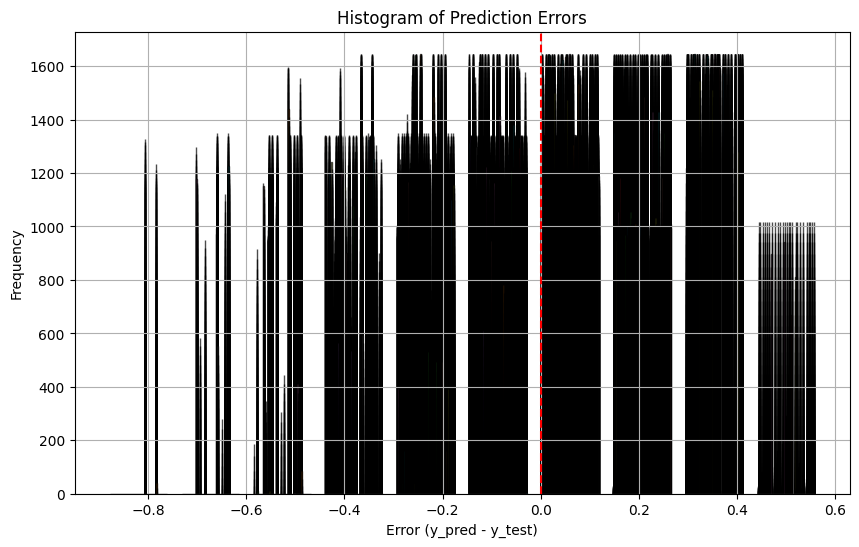

In [ ]:
# Plotting the histogram of errors

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=10, edgecolor='k', alpha=0.7)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error (y_pred - y_test)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--')  # Line at zero error
plt.grid()
plt.show()

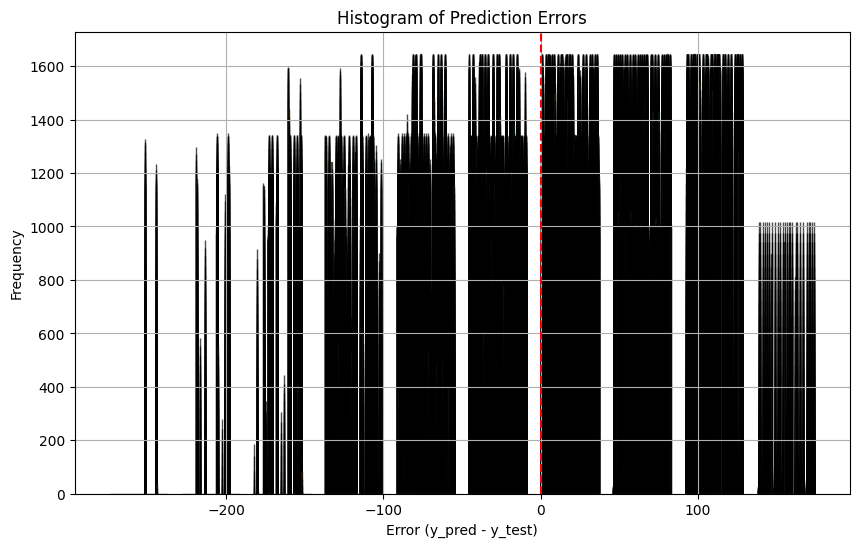

In [33]:
errors = y_pred - y_test  # Flatten in case they are 2D arrays

# Plotting the histogram of errors

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=10, edgecolor='k', alpha=0.7)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error (y_pred - y_test)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--')  # Line at zero error
plt.grid()
plt.show()

#### Regression Observations

* The LSTMs initially had problems with early stagnation and high losses during training.
* Scaling the target ttf values fixed this issue.
* To compare the non-temporal models and LSTM/GRUs, we can use the regression meterics obtained after inverse transforming the y_pred values obtained.
* The R^2 stays the same before and after transformation and is better than the ones for the random forest and linear regressors. [0.4, 0.6 -> 0.7]
* The MAE is significantly higher for the non temporal regressors averaging around 38 MAE while it's about 21 for inverse transforming for the GRU regressor. [0.06 before transformation.]

### Extra: time series prediction with convolutional neural networks

As an extension, you can try to train a convolutional neural network on the sequences. You can think of each sequence as a 2D array, similar to an image. 
So training the CNN will be comparable to training an image classifier, only here the image is a sequence of sensor values and the class is whether or not it fails within 50 cycles.

Also try the regression problem via a convolutional neural network where you predict the ttf.

In [6]:
train_df = df[df["engine_id"]<=75].drop("ttf", axis =1 )

test_df = df[df["engine_id"]>75].drop("ttf", axis =1 )


In [26]:
# there are about 200 samples for each engine
SEQ_LENGTH = 100

X_train, y_train = [], []
for engine_id in train_df['engine_id'].unique():
    engine_data = train_df[train_df['engine_id'] == engine_id]
    engine_data_padded = pad_sequences(engine_data, SEQ_LENGTH)
    seqs, targets = create_sequences(engine_data_padded, SEQ_LENGTH)
    X_train.append(seqs)
    y_train.append(targets)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Prepare sequences for testing
X_test, y_test = [], []
for engine_id in test_df['engine_id'].unique():
    engine_data = test_df[test_df['engine_id'] == engine_id]
    engine_data_padded = pad_sequences(engine_data, SEQ_LENGTH)
    seqs, targets = create_sequences(engine_data_padded, SEQ_LENGTH)
    X_test.append(seqs)
    y_test.append(targets)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

scaler = MinMaxScaler()

n_features = X_train.shape[2]

# Flatten data for scaling
X_train_flat = X_train.reshape(-1, n_features)
X_test_flat = X_test.reshape(-1, n_features)

# Fit scaler on training data
scaler.fit(X_train_flat)

# Transform sequences
X_train = scaler.transform(X_train_flat).reshape(X_train.shape)
X_test = scaler.transform(X_test_flat).reshape(X_test.shape)


X_train = X_train.reshape((X_train.shape[0], SEQ_LENGTH, X_train.shape[2], 1))  # Add a channel dimension
X_test = X_test.reshape((X_test.shape[0], SEQ_LENGTH, X_test.shape[2], 1))  # Add a channel dimension

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7734, 100, 26) (7734,)
(2997, 100, 26) (2997,)
(7734, 100, 26, 1) (7734,)
(2997, 100, 26, 1) (2997,)


In [33]:
# Classification with a CNN

# Custom CNN classifier

adam = tf.keras.optimizers.Adam()

# Neural network parameters
#-----------------------------------------------
#-----------------------------------------------

batch_size = 32 #
epochs = 150 #

#-----------------------------------------------
#-----------------------------------------------

num_classes = 2
input_shape = (100,26,1)

# Model
model_car = Sequential()
#-----------------------------------------------
#-----------------------------------------------
model_car.add(Conv2D(64, kernel_size=(3, 3), input_shape=input_shape))
#-----------------------------------------------
model_car.add(BatchNormalization())
#-----------------------------------------------
model_car.add(Activation('relu'))
#-----------------------------------------------
model_car.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
model_car.add(Conv2D(64, kernel_size=(3, 3)))
#-----------------------------------------------
model_car.add(BatchNormalization())
#-----------------------------------------------
model_car.add(Activation('relu'))
#-----------------------------------------------
model_car.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
#-----------------------------------------------
#-----------------------------------------------
model_car.add(Flatten())
model_car.add(Dropout(0.6)) # Value between 0 and 1
model_car.add(Dense(64, activation='relu'))
#-----------------------------------------------
#-----------------------------------------------
model_car.add(Dropout(0.6)) # Value between 0 and 1
#-----------------------------------------------
#-----------------------------------------------
model_car.add(Dense(1, activation='sigmoid'))

model_car.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class_weight = {0:1,1:1}
# Trainen van het CNN
history = model_car.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.25,
                        verbose=1,
                        class_weight=class_weight,
                        callbacks=early_stopping)

/home/sathv/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7332 - loss: 0.6905 - val_accuracy: 0.5584 - val_loss: 0.7010
Epoch 2/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8665 - loss: 0.2948 - val_accuracy: 0.6308 - val_loss: 0.6491
Epoch 3/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8974 - loss: 0.2439 - val_accuracy: 0.8878 - val_loss: 0.2509
Epoch 4/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9094 - loss: 0.2243 - val_accuracy: 0.9007 - val_loss: 0.3251
Epoch 5/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9147 - loss: 0.2164 - val_accuracy: 0.9157 - val_loss: 0.2335
Epoch 6/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9119 - loss: 0.2117 - val_accuracy: 0.9147 - val_loss: 0.2278
Epoch 7/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9096 - loss: 0.2130 - val_accuracy: 0.9271 - val_loss: 0.1850
Epoch 8/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9228 - loss: 0.1830 - val_acc

In [30]:
# Predictions on the test set
# (128,64) neurons on the conv2d layers

predictions = model_car.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

# Accuracy and confusion matrix
accuracy = accuracy_score(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)
report = classification_report(y_test, predicted_classes)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print(f"\nAccuracy: {accuracy*100:.3f} %")



94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      1737
           1       0.99      0.83      0.91      1260

    accuracy                           0.93      2997
   macro avg       0.94      0.92      0.92      2997
weighted avg       0.93      0.93      0.93      2997

Confusion Matrix:
 [[1730    7]
 [ 209 1051]]

Accuracy: 92.793 %


In [28]:
# Predictions on the test set
# (64,64) neurons on the conv2d layers

predictions = model_car.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

# Accuracy and confusion matrix
accuracy = accuracy_score(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)
report = classification_report(y_test, predicted_classes)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print(f"\nAccuracy: {accuracy*100:.3f} %")



94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      1737
           1       0.91      0.95      0.93      1260

    accuracy                           0.94      2997
   macro avg       0.94      0.94      0.94      2997
weighted avg       0.94      0.94      0.94      2997

Confusion Matrix:
 [[1618  119]
 [  65 1195]]

Accuracy: 93.861 %


In [15]:
# Predictions on the test set
# (64,32) neurons on the conv2d layers

predictions = model_car.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

# Accuracy and confusion matrix
accuracy = accuracy_score(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)
report = classification_report(y_test, predicted_classes)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print(f"\nAccuracy: {accuracy*100:.3f} %")



94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      1737
           1       0.99      0.87      0.92      1260

    accuracy                           0.94      2997
   macro avg       0.95      0.93      0.94      2997
weighted avg       0.94      0.94      0.94      2997

Confusion Matrix:
 [[1728    9]
 [ 169 1091]]

Accuracy: 94.061 %


In [58]:
# Regression with a CNN

SEQ_LENGTH = 100

# Prepare training data
X_train, y_train = [], []
for engine_id in train_df_regression['engine_id'].unique():
    engine_data = train_df_regression[train_df_regression['engine_id'] == engine_id].select_dtypes(include=[np.number])
    engine_data_padded = pad_sequences(engine_data, SEQ_LENGTH)
    seqs, targets = create_sequences(engine_data_padded, SEQ_LENGTH)
    X_train.append(seqs)
    y_train.append(targets)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Prepare testing data
X_test, y_test = [], []
for engine_id in test_df_regression['engine_id'].unique():
    engine_data = test_df_regression[test_df_regression['engine_id'] == engine_id].select_dtypes(include=[np.number])
    engine_data_padded = pad_sequences(engine_data, SEQ_LENGTH)
    seqs, targets = create_sequences(engine_data_padded, SEQ_LENGTH)
    X_test.append(seqs)
    y_test.append(targets)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7734, 100, 26) (7734,)
(2997, 100, 26) (2997,)


In [61]:

scaler = MinMaxScaler()

n_features = X_train.shape[2]

# Flatten data for scaling
X_train_flat = X_train.reshape(-1, n_features)
X_test_flat = X_test.reshape(-1, n_features)

# Fit scaler on training data
scaler.fit(X_train_flat)

# Transform sequences
X_train = scaler.transform(X_train_flat).reshape(X_train.shape)
X_test = scaler.transform(X_test_flat).reshape(X_test.shape)


X_train = X_train.reshape((X_train.shape[0], SEQ_LENGTH, X_train.shape[2], 1))  # Add a channel dimension
X_test = X_test.reshape((X_test.shape[0], SEQ_LENGTH, X_test.shape[2], 1))  # Add a channel dimension

y_train_flat = y_train.reshape(-1, 1)
y_test_flat = y_test.reshape(-1, 1)


scaler_y = MinMaxScaler()
scaler_y.fit(y_train_flat)

# Scale y data
y_train_scaled = scaler_y.transform(y_train_flat).reshape(y_train.shape)
y_test_scaled = scaler_y.transform(y_test_flat).reshape(y_test.shape)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7734, 100, 26, 1) (7734,)
(2997, 100, 26, 1) (2997,)


In [54]:
# Classification with a CNN

# Custom CNN classifier

adam = tf.keras.optimizers.Adam()

# Neural network parameters
#-----------------------------------------------
#-----------------------------------------------

batch_size = 32 #
epochs = 150 #

#-----------------------------------------------
#-----------------------------------------------

num_classes = 2
input_shape = (100,26,1)

# Model
model_car = Sequential()
#-----------------------------------------------
#-----------------------------------------------
model_car.add(Conv2D(128, kernel_size=(3, 3), input_shape=input_shape))
#-----------------------------------------------
model_car.add(BatchNormalization())
#-----------------------------------------------
model_car.add(Activation('relu'))
#-----------------------------------------------
model_car.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
model_car.add(Conv2D(64, kernel_size=(3, 3)))
#-----------------------------------------------
model_car.add(BatchNormalization())
#-----------------------------------------------
model_car.add(Activation('relu'))
#-----------------------------------------------
model_car.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
#-----------------------------------------------
#-----------------------------------------------
model_car.add(Flatten())
model_car.add(Dropout(0.6)) # Value between 0 and 1
model_car.add(Dense(64, activation='relu'))
#-----------------------------------------------
#-----------------------------------------------
model_car.add(Dropout(0.6)) # Value between 0 and 1
#-----------------------------------------------
#-----------------------------------------------
model_car.add(Dense(1, activation='sigmoid'))

model_car.compile(loss='mean_squared_error',
                  optimizer=adam)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class_weight = {0:1,1:1}
# Trainen van het CNN
history = model_car.fit(X_train, y_train_scaled,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.25,
                        verbose=1,
                        class_weight=class_weight,
                        callbacks=early_stopping)

/home/sathv/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0712 - val_loss: 0.1180
Epoch 2/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0685 - val_loss: 0.1180
Epoch 3/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0657 - val_loss: 0.1180
Epoch 4/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0667 - val_loss: 0.1180
Epoch 5/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0689 - val_loss: 0.1180
Epoch 6/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0675 - val_loss: 0.1180
Epoch 7/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0681 - val_loss: 0.1180
Epoch 8/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0659 - val_loss: 0.1180
Epoch 9/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0663 - val_loss: 0.1180
Epoch 10/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0654 - val_loss: 0.1180
Epoch 11/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0678 - val_loss: 0.1180


In [63]:
y_pred_scaled = model_car.predict(X_test)

mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
mae_scaled = mean_absolute_error(y_test_scaled, y_pred_scaled)
r2_scaled = r2_score(y_test_scaled, y_pred_scaled)

print("Scaled predictions -")
print(f"MSE: {mse_scaled}")
print(f"MAE: {mae_scaled}")
print(f"R2: {r2_scaled}\n")

y_pred = scaler_y.inverse_transform(y_pred_scaled)
mse_original = mean_squared_error(y_test, y_pred)
mae_original = mean_absolute_error(y_test, y_pred)
r2_original = r2_score(y_test, y_pred)

print("Inverse transformed predictions - ")
print(f"MSE: {mse_original}")
print(f"MAE: {mae_original}")
print(f"R2: {r2_original}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Scaled predictions -
MSE: 0.11716333391448555
MAE: 0.27510971531325884
R2: -1.8247117694592299

Inverse transformed predictions - 
MSE: 8042.559893225948
MAE: 72.07874541207381
R2: -1.824711561203003
